# Data Wrangling - Assignment 1

## 0. Setup

In [ ]:
%pip install -r requirements.txt

In [2]:
import json
from pathlib import Path
from shutil import rmtree
from typing import Dict, List, Tuple

import numpy as np
import cv2 as cv
import pandas as pd
import requests
import folium
import geopandas
from shapely.geometry import Point
from shapely.geometry import MultiPolygon
from shapely.ops import transform
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt

%matplotlib inline

## 1. Fetching Data and Preprocessing

If `FETCH_DATA` is set to True, the raw data from previous executions will be deleted. All data is then fetched again from these data sources:


| Data                      | Source                         | URL                                                                                      | Filetype  | Access Date |
|:---                       |:---                            |:---                                                                                      | :---      | :--- |
| Basic Data on Communes <br>(from 2021)    | Bundesamt für Statistik        | https://dam-api.bfs.admin.ch/hub/api/dam/assets/15864450/master                          | XLSX File | 01.03.2025 |
| Coat of Arms of Communes  | Staatsarchiv Kanton Luzern     | https://staatsarchiv.lu.ch/kantonsgeschichte/gemeinden/Gemeindewappen/*\[commune\]*      | JPG Files | 05.03.2025 | 
| Points of Interest (Restaurants) | Overpass API (OpenStreetMap)      | https://overpass-api.de/api/interpreter  | JSON | 17.03.2025 |
| Anzahl Hunde pro Gemeinde | Team Tierstatistik Identitas AG (via OpenData)    | https://tierstatistik.identitas.ch/data/dogs-map-commune.csv <br> https://opendata.swiss/de/dataset/hunde-verteilung-pro-gemeinde                           | CSV File  | 10.03.2025 |
| Spacial data from communes in Switzerland <br>(from 2021) | Bundesamt für Landestopografie (swisstopo); <br> Geojson created by cividi based on the swisstopo data  | https://github.com/cividi/ch-municipalities  | geojson File | 19.03.2025 |

The data from all sources has been downloaded and persisted on the 17.03.2025. Since URLs and APIs or the data behind them can change, it is suggested to set `FETCH_DATA = False` use the persisted data in `./raw_data`.

In [3]:
FETCH_DATA = False

# Directories
RAW_DATA_PATH = Path().cwd() / 'raw_data'
COAT_OF_ARMS_PATH = RAW_DATA_PATH / 'coat_of_arms'
MAP_PATH = RAW_DATA_PATH / 'map'

# Files
COMMUNES_PATH = RAW_DATA_PATH / 'communes.xlsx'
POI_PATH = MAP_PATH / 'restaurants.json'
BOUNDARIES_PATH = MAP_PATH / 'communes.geojson'
DOGS_PATH = RAW_DATA_PATH / "dogs.csv"

In [4]:
def delete_raw_data(raw_data_dir: Path, subdirs: List[Path]) -> None:
    '''
    Deletes all raw data if the raw data directory exists.

    Parameters
    ----------
    raw_data_dir : Path
        The path of the directory that contains the raw data.
    subdirs : List[Path]
        A list of subdirs as an absolute path to create inside the raw data directory.

    Returns
    -------
    None
    '''
    if raw_data_dir.exists():
        rmtree(raw_data_dir)
    
    raw_data_dir.mkdir()

    for dir in subdirs:
        dir.mkdir()

In [5]:
if FETCH_DATA:
    delete_raw_data(RAW_DATA_PATH, [COAT_OF_ARMS_PATH, MAP_PATH])

### 1.1. Basic Data: XLSX File for Data on all Comunes

#### 1.1.1. Fetch XLSX File

In [6]:
def download_binary_file(url: str, destination_file: Path) -> None:
    '''
    Downloads a file from a given URL via a HTTP GET request.

    Parameters
    ----------
    url : str
        The URL of the file.
    destination_dir : Path
        The path of the file in which the binary data should be stored.
    
    Returns
    -------
    None
    '''
    request = requests.get(url)
    request.raise_for_status()

    with open(destination_file, "wb") as f:
        f.write(request.content)

In [7]:
if FETCH_DATA:
    bfs_url = 'https://dam-api.bfs.admin.ch/hub/api/dam/assets/15864450/master'
    download_binary_file(bfs_url, destination_file=COMMUNES_PATH)

#### 1.1.2. Preprocess XLSX File

In [8]:
def preprocess_communes_df(raw_communes: pd.DataFrame, min_bfs_nr: int, max_bfs_nr: int) -> Tuple[pd.DataFrame, Dict[int, str]]:
    '''
    Applies the preprocessing steps to the raw communes DataFrame.

    Parameters
    ----------
    raw_communes : DataFrame
        The raw DataFrame after loading from an excel file.
    min_bfs_nr : int
        The BFS number
        (`see Wikipedia <https://en.wikipedia.org/wiki/Community_Identification_Number#Switzerland>`_)
        of the first commune to include in the preprocessed DataFrame.
    max_bfs_nr : int
        The BFS number of the last commune to include in the preprocessed
        DataFrame (The commune with this number will be included in the
        preprocessed DataFrame).
    
    Returns
    -------
    communes : pd.DataFrame
        The complete preprocessed DataFrame.
    communes_names : dict
        A DataFrame that contains only the names of the communes in the
        the range of BFS numbers passed to this function.
    '''
    
    # Improve column names by removing:
    # - unnecessary'-' characters
    # - unnecessary references like '1)'
    raw_communes.rename(
        columns=lambda name: name.replace('-', '') if 'Jahre' not in name else name,
        inplace=True
    )
    raw_communes.rename(
        columns = {
            raw_communes.columns[14]: raw_communes.columns[14][:-3],
            raw_communes.columns[32]: raw_communes.columns[32][:-3],
        },
        inplace=True
    )

    raw_communes.drop(labels=np.nan, axis=0, inplace=True)
    raw_communes.set_index(raw_communes.index.astype('int'), inplace=True)

    # select communes, that have BFS numbers in the given range
    communes = raw_communes.loc[min_bfs_nr:max_bfs_nr]

    # Remove the LU suffix present for some communes
    communes.loc[:, 'Gemeindename'] = communes.loc[:, "Gemeindename"].str.replace(
        r'(?P<name>\w+) \(LU\)',
        lambda m: m.group('name'),
        regex=True,
    )

    communes_names = communes.loc[:, 'Gemeindename'].sort_values().to_dict()
    return communes, communes_names

In [9]:
communes = pd.read_excel(
    COMMUNES_PATH,
    skiprows=[0, 1, 2, 3, 4, 6, 7],
    skipfooter=16,
    index_col=0,
)

communes_lu, communes_lu_names = preprocess_communes_df(
    raw_communes=communes,
    min_bfs_nr=1001,
    max_bfs_nr=1151,
)

### 1.2. Additional Data: Gemeindewappen 

#### 1.2.1. Fetch JPG Files

In [10]:
def download_coat_of_arms(source_url: str, destination_dir: Path, commune_names: Dict[int, str], logging: bool=False) -> None:
    '''
    Downloads images of all coats of arms from Staatsarchiv Luzern.

    Parameters
    ----------
    source_url : str
        The URL to download the images from.
    destination_dir : Path
        The Path of the directory where the coats of arms should be stored.
    commune_names : dict
        A dict that matches all BFS numbers of the communes to their names.
    logging : bool
        If True, logging messages will be printed. Defaults to False.
    
    Returns
    -------
    None
    '''
    # fetch images of coat of arms for all communes
    for cid, commune in commune_names.items():
        # handle concatenated and multi-word commune names
        if '-' in commune:
            commune = commune.split('-')[0]
        elif ' ' in commune:
            commune = commune.split(' ')[0]
        # The coat of arms of 'Willisau' is stored under 'Willisau-Stadt'
        # in https://staatsarchiv.lu.ch
        elif commune == 'Willisau':
            commune = 'Willisau-Stadt'

        current_url = source_url + commune
        if logging:
            print(f'Fetching {current_url}')
        request = requests.get(current_url)
        request.raise_for_status()

        soup = BeautifulSoup(request.text, 'html.parser')
        img = soup.find(id='maincontent_1_imgImage')
        img_url = 'https://staatsarchiv.lu.ch' + img.get('src')

        img_request = requests.get(img_url)
        img_request.raise_for_status()

        current_img_path = destination_dir / f'{cid}.jpg'
        with open(current_img_path, "wb") as f:
            f.write(img_request.content)

In [11]:
if FETCH_DATA:
    sa_lu_url = 'https://staatsarchiv.lu.ch/kantonsgeschichte/gemeinden/Gemeindewappen/'
    download_coat_of_arms(
        sa_lu_url, COAT_OF_ARMS_PATH,
        communes_lu_names, logging=True
    )

### 1.3. Additional Data: Points of Interest - Restaurants



#### 1.3.1. Fetch Restaurants from OpenStreetMap

In [12]:
def download_points_of_interest(source_url: str, destination_file: Path, amenity: str) -> None:
    '''
    Downloads a JSON file containing Points of Interest which belong to a ``amenity`` from
    the OpenStreetMap API (OverpassAPI) using a HTTP POST request. The coordinate
    reference system used is EPSG:4326.

    Parameters
    ----------
    source_url : str
        The URL to download the restaurant points from.
    destination_dir : Path
        The Path of the directory where the downloaded data should be stored.
    amenity : str
        Which amenity should be fetched from OpenStreetMap. See `OpenStreetMap Wiki
        <https://wiki.openstreetmap.org/wiki/Key:amenity>`_ for a list of all
        possible values.
    
    Returns
    -------
    None
    '''

    # OverpassQL query to get all restaurants in the bounding box of canton lucerne
    payload = {
        'data': f'''
        [out:json]
        [timeout:90]
        ;
        node
            ["amenity"="{amenity}"]
            (46.771849614677,7.8318786621094,47.283887179484,8.514404296875);
        out;
        '''
    }

    # Fetch data from OverpassAPI
    request = requests.post(source_url, data=payload)
    request.raise_for_status()

    with open(destination_file, 'wt', encoding='utf-8') as f:
        f.write(request.text)

In [13]:
def download_text_file(url: str, destination_file: Path) -> None:
    '''
    Downloads a text file from the given ``url`` via a HTTP GET request.

    Parameters
    ----------
    url : str
        The URL of the file.
    destination_file : Path
        The path of the file in which the data should be stored.
    Returns
    -------
    None
    '''
    request = requests.get(url)
    request.raise_for_status()

    with open(destination_file, "wt") as f:
        f.write(request.text)

In [14]:
if FETCH_DATA:
    osm_api_url = 'https://overpass-api.de/api/interpreter'
    boundaries_url = 'https://github.com/cividi/ch-municipalities/releases/download/v0.2/gemeinden.geojson'
    download_points_of_interest(
        source_url=osm_api_url,
        destination_file=POI_PATH,
        amenity='restaurant'
    )
    download_text_file(boundaries_url, BOUNDARIES_PATH)

#### 1.3.2 Preprocess Points of Interest JSON and CommuneBoundaries from GPKG

In [78]:
def filter_geojson_for_lu(geojson_file: Path) -> str:
    '''
    Filters out all data from a ``geojson_file`` that is not about
    communes in the canton of lucerne.

    Parameters
    ----------
    geojson_file : pathlib.Path
        The path pointing to the original geojson, which needs
        to be filtered.
    
    Returns
    -------
    str
        A geojson string containing the data for canton lucerne.
    '''
    # Load json for CH
    with open(geojson_file) as f:
        gadm_json = json.load(f)

    # Only keep communes of canton lucerne
    gadm_communes_lu = filter(
        lambda f: f['properties']['kanton.NAME'] == 'Luzern',
        gadm_json['features']
    )

    # remove dot from key names, since folium cannot handle it
    gadm_json['features'] =  list(gadm_communes_lu)

    return json.dumps(gadm_json)

def get_points_within_area(area: MultiPolygon, poi_df: geopandas.GeoDataFrame):
    '''
    Count how many points of interest there are within the `area` of a commune.

    Parameters
    ----------
    area : MultiPolygon
        The area of a commune as a shapely MultiPolygon.
    poi_df : geopandas.GeoDataFrame
        A GeoDataFrame containing the points in geometry column called
        `Point`.

    Returns
    -------
    int
        The number of points that are within the `area`.
    '''
    return poi_df.loc[:, "Point"].apply(lambda p: p.within(area)).sum()

def count_restaurants_per_commune(restaurant_pois_file: Path, geojson_file: Path) -> pd.DataFrame:
    '''
    Counts the number of restaurants per commune using the restaurant
    POIs from a JSON file and the commune area from a geojson file.

    Parameters
    ----------
    restaurant_pois_file : pathlib.Path
        A json file downloaded from OpenStreetMap that contains
        the points of interest for restaurants.
    geojson_file : pathlib.Path
        A geojson file downloaded from gadm.org, which contains
        data for communes in Switzerland.

    Returns
    -------
    pd.DataFrame
        A pandas DataFrame, containing the number of restaurants
        per commune.
    '''
    with open(restaurant_pois_file) as f:
        poi_json = json.load(f)

    # Create Restaurants GeoDataFrame
    restaurants = list(map(lambda e: [ e['tags']['amenity'],
                           Point(e['lat'], e['lon']) ], poi_json['elements']))
    rest_df = geopandas.GeoDataFrame(
        restaurants,
        columns=['Amenity', 'Point'],
        geometry='Point',
        crs='EPSG:4326'
    )

    # Load geojson as GeoDataFrame
    geojson_lu = filter_geojson_for_lu(geojson_file)
    communes_lu_area_df = geopandas.read_file(geojson_lu)
    
    # reverse coordinates to lat, lon format and ignore Z coordinate
    communes_lu_area_df["geometry"] = communes_lu_area_df.loc[:, "geometry"].apply(
        lambda polygon: transform(lambda x, y, _: (y, x), polygon)
    )

    communes_lu_area_df['Restaurant_count'] = communes_lu_area_df.loc[:, 'geometry'].apply(
        get_points_within_area,
        args=(rest_df,)
    )

    return communes_lu_area_df.loc[:, ["gemeinde.BFS_NUMMER", "gemeinde.NAME", 'Restaurant_count']].copy()

In [68]:
df_rest_count = count_restaurants_per_commune(POI_PATH, BOUNDARIES_PATH)
df_rest_count.to_csv("out.csv")

,gemeinde.BFS_NUMMER,gemeinde.NAME,kanton.KUERZEL,kanton.NAME,geometry
0,1001,Doppleschwand,LU,Luzern,"MULTIPOLYGON Z (((8.05803 47.0288 604.6025, 8...."
1,1002,Entlebuch,LU,Luzern,"MULTIPOLYGON Z (((8.08585 46.90607 1911.1625, ..."
2,1004,Flühli,LU,Luzern,"MULTIPOLYGON Z (((8.04694 46.78711 2349.03, 8...."
3,1005,Hasle,LU,Luzern,"MULTIPOLYGON Z (((8.06213 46.90957 1927.70375,..."
4,1007,Romoos,LU,Luzern,"MULTIPOLYGON Z (((8.05803 47.0288 604.6025, 8...."
...,...,...,...,...,...
75,1145,Ufhusen,LU,Luzern,"MULTIPOLYGON Z (((7.87353 47.12406 630.66625, ..."
76,1146,Wauwil,LU,Luzern,"MULTIPOLYGON Z (((8.01902 47.1924 682.07, 8.01..."
77,1147,Wikon,LU,Luzern,"MULTIPOLYGON Z (((7.9616 47.25457 449.10625, 7..."
78,1150,Zell,LU,Luzern,"MULTIPOLYGON Z (((7.93375 47.16129 611.27, 7.9..."


In [76]:
# folium map, centered in Romoos
folium_map = folium.Map(
    location=[47.011163,8.028080],
    zoom_start=12,
    tiles="OpenStreetMap"
)

# replace gemeinde.BFS_NUMMER with gemeinde_BFS_NUMMER
# since folium cannot handle it
folium_json_string = filter_geojson_for_lu(BOUNDARIES_PATH).replace(
    'gemeinde.BFS_NUMMER', 
    'gemeinde_BFS_NUMMER'
)

# add the geojson for canton lucerne to the map
geojson_map = folium.GeoJson(
        folium_json_string,
        style_function=lambda _: {
            'fillColor': 'black',
            'color': 'black',
            'weight': 2,
            'fill_opacity': 0.4,
        }
    )
geojson_map.add_to(folium_map)

folium_map

### 1.4. Additional Data: Dogs per Commune

#### 1.4.1. Download CSV File

In [79]:
if FETCH_DATA:
    dogs_url = 'https://tierstatistik.identitas.ch/data/dogs-map-commune.csv'
    download_text_file(dogs_url, DOGS_PATH)

#### 1.4.2. Preprocess CSV file

In [192]:
def preprocess_dog_df(raw_dogs: pd.DataFrame, commune_names: Dict[int, str]) -> Tuple[pd.DataFrame, Dict[int, str]]:
    '''
    Applies the preprocessing steps to the raw dogs DataFrame.

    Parameters
    ----------
    raw_dogs : DataFrame
        The raw DataFrame after loading from an csv file.
    commune_names : Dict[int, str]
        A dictionary mapping each commune's BFS number to its name.
        Only dog counts for communes included in this dictionary will
        be considered.
    Returns
    -------
    dogs : pd.DataFrame
        The complete preprocessed DataFrame.
    '''
    
    new_dog_df = raw_dogs.rename(
        columns = {
            'commune': 'Gemeindename',
            'countPerSurfacekm2': 'Anzahl Hunde pro km2',
            'countPer100Inhabitants': 'Anzahl Hunde pro 100 Einwohner',
            'count': 'Anzahl Hunde',
        }
    )

    new_dog_df.drop(['top5breeds', 'top5names'], axis=1, inplace=True)

     # Remove the LU suffix present for some communes
    new_dog_df.loc[:, 'Gemeindename'] = new_dog_df.loc[:, "Gemeindename"].str.replace(
        r'(?P<name>\w+) \(LU\)',
        lambda m: m.group('name'),
        regex=True,
    )

    # select only select dog data for communes from the list
    dogs_lu = new_dog_df.loc[new_dog_df.loc[:, 'Gemeindename'].isin(commune_names.values())].copy()
    
    # add BFS number as index
    name2nr = { name : nr for nr, name in commune_names.items() } 
    dogs_lu['Gemeindecode'] = dogs_lu.loc[:, 'Gemeindename'].apply(lambda name : name2nr[name])
    
    dogs_lu.set_index('Gemeindecode', inplace=True, drop=True)
    dogs_lu.sort_values(by='Gemeindecode', inplace=True)

    return dogs_lu

In [193]:
dogs = pd.read_csv(DOGS_PATH, sep=';', skiprows=1)
display(dogs.loc[dogs["commune"] == 'Honau'])

honau_row = pd.DataFrame(
    {'commune': 'Honau',
     'count': 0,
     'countPerSurfacekm2': 0,
     'countPer100Inhabitants': 0,
     'top5breeds':np.nan,
     'top5names': np.nan
    },
    index=[dogs.shape[0]])
dogs = pd.concat([dogs, honau_row])

df_dogs = preprocess_dog_df(dogs, communes_lu_names)

,commune,count,countPerSurfacekm2,countPer100Inhabitants,top5breeds,top5names


As shown above, the commune Honau is not in included in this dataset. The number of dogs is assumed to be 0, because in the dataset from January 2025 the commune was still included and had a count of 0.

## 2. Feature Extraction

Extract the relevant features from all downloaded data sources. 

### 2.1. Extract Relevant Features from communes file

The only a part of the columns in the communes file is used. 

In [194]:
base_data = communes_lu.iloc[:, [0, 1, 3, 5, 6, 7, 14, 15, 17, 19, 29, 30]]
base_data

,Gemeindename,Einwohner,Bevölkerungsdichte pro km²,0-19 Jahre,20-64 Jahre,65 Jahre und mehr,Gesamtfläche in km²,Siedlungsfläche in %,Landwirtschaftsfläche in %,Wald und Gehölze in %,Leerwohnungsziffer,Neu gebaute Wohnungen pro 1000 Einwohner
Gemeindecode,,,,,,,,,,,,
1001,Doppleschwand,789,113.525180,26.742712,58.681876,14.575412,6.95,5.755396,55.683453,36.115108,1.704545,1.272265
1002,Entlebuch,3280,57.644991,21.798780,59.664634,18.536585,56.90,3.686151,49.552396,42.829559,1.092896,8.446456
1004,Flühli,1929,17.833041,21.876620,60.290306,17.833074,108.17,2.497918,44.527708,38.236655,1.052150,5.112474
1005,Hasle,1736,43.066237,22.695853,59.907834,17.396313,40.31,3.248202,49.094967,39.573518,2.241594,17.694064
1007,Romoos,659,17.625033,22.003035,59.787557,18.209408,37.39,2.088353,35.796519,60.803213,0.874636,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1145,Ufhusen,888,72.727273,21.959459,60.585586,17.454955,12.21,5.496308,73.256768,20.918786,1.250000,15.503876
1146,Wauwil,2261,763.851351,20.477665,64.838567,14.683768,2.96,21.088435,68.707483,10.204082,4.360465,11.483693
1147,Wikon,1520,183.574879,22.828947,59.210526,17.960526,8.28,9.650181,38.359469,51.869723,0.722543,6.557377


### 2.2. Extract Features from coats of arms

#### Color Red in HSV Color Model:

$H \in [0, 16] = [0, 8]$ in OpenCV $ \land$ $H \in [343,359] = [171, 179]$ in OpenCV

$S \ge 45 \% \approx 115 $ in OpenCV

$V \ge 45 \% \approx 115 $ in OpenCV

#### Color Yellow in HSV Color Model:

$H \in [45, 65] \approx [23, 32]$ in OpenCV

$S \ge 35 \% \approx 90$ in OpenCV

$V \ge 35 \% \approx 90 $ in OpenCV

In [195]:
def count_background_pixels(image: np.ndarray, logging: bool=False) -> int:
    '''
    Count the number of background pixels in ``image`` by:
    - converting the ``image`` to grayscale
    - then applying a threshold found using Otsu's method
    - finally count the number pixels in the connected component
      to which the pixel in the top right corner belongs to.

    Parameters
    ----------
    image : numpy.ndarray
        The image to count the background pixels of.
    logging : bool
        If True, logging messages will be printed. Defaults to False.
    
    Returns
    -------
    bg_count : int
        The number of background pixels.
    '''
    gray_img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    found_th, thresh = cv.threshold(gray_img, 0, 255,
                                    cv.THRESH_BINARY+cv.THRESH_OTSU)
    if logging:
        print(f'Threshold found with Otsu Methods: {found_th}')

    nr_of_labels, labels = cv.connectedComponents(thresh)
    if logging:
        print(f'Number of Labels: {nr_of_labels}')

    bg_label = labels[0, 0]
    if logging:
        print(f'Label of background: {bg_label}')

    return labels[labels == bg_label].size



In [196]:
def plot_selected_color_range(image: np.ndarray, selected_px_locations: np.ndarray) -> None:
    '''
    Plots a comparison between the original image and the selected
    color range.

    Parameters
    ----------
    image : numpy.ndarray
        The original image.
    selected_px_locations : numpy.ndarray
        An numpy.ndarray in which the pixels that belong to a color range
        are set to 255, while all other pixels are 0.

    Returns
    -------
    None
    '''
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(selected_px_locations, cmap='gray')
    axes[0].set_title('Extracted Parts')
    axes[1].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    axes[1].set_title('Original')

    for ax in axes:
        ax.set_axis_off()
    plt.show()

In [197]:
def calculate_color_ratio(image_path: Path, color_range1: Tuple[np.array, np.array],
                          color_range2: Tuple[np.array, np.array] | None = None,
                          plot_image: bool = False) -> float:
    '''
    Calculates which ratio of pixels in an image fall in one or two
    specified color ranges.

    Parameters
    ----------
    image_path : Path
        The path to the image file.
    color_range1 : Tuple
        A tuple containing two arrays that define the lower and upper bounds
        of the first color range in the HSV color space.
    color_range2 : Tuple | None
        An optional tuple for a second color range. Its format is the same
        as for ``color_range1``.
    plot_image : bool
        If True, the image and the selected colors will be plotted.
        Defaults to False.
    
    Returns
    -------
    color_ratio : float
        The ratio of pixels in the image that fall within the specified
        color range(s).
    '''
    img = cv.imread(image_path)
    if img is None:
        raise ValueError('Failed to load image using the given Path.')

    # Convert image to HSV color model
    hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    # locations of the pixels inside the given range
    locations_range1 = cv.inRange(hsv_img, color_range1[0], color_range1[1])
    color_px_locations = locations_range1

    if color_range2:
        locations_range2 = cv.inRange(hsv_img, color_range2[0], color_range2[1])
        color_px_locations = cv.bitwise_or(locations_range1, locations_range2)

    bg_count = count_background_pixels(img)
    if plot_image:
        print(f'Number of background pixels: {bg_count}')
        plot_selected_color_range(img, color_px_locations)

    color_px_count = np.count_nonzero(color_px_locations)
    color_px_ratio = color_px_count / (color_px_locations.size - bg_count)
    return color_px_ratio

In [198]:
# red hue in HSV color model
red_start = ( np.array([0, 115, 115]), np.array([8, 255, 255]) )
red_end = ( np.array([171, 115, 115]), np.array([179, 255, 255]) )

# yellow hue in HSV color model
yellow_start = ( np.array([23, 90, 90]), np.array([32, 255, 255]) )

imgs = sorted(list(COAT_OF_ARMS_PATH.glob('*.jpg')))

color_ratios_red = {
    img_path.stem: calculate_color_ratio(img_path, red_start, red_end)
    for img_path in imgs
}
color_ratios_yellow = {
    img_path.stem: calculate_color_ratio(img_path, yellow_start)
    for img_path in imgs
}

df_color_ratio = pd.DataFrame({'Gemeindecode': color_ratios_red.keys(),
                             'Rotanteil Wappen': color_ratios_red.values(),
                             'Gelbanteil Wappen': color_ratios_yellow.values(),
                             })
df_color_ratio.set_index('Gemeindecode', inplace=True)

df_color_ratio.index = df_color_ratio.index.astype("int")

Number of background pixels: 19742


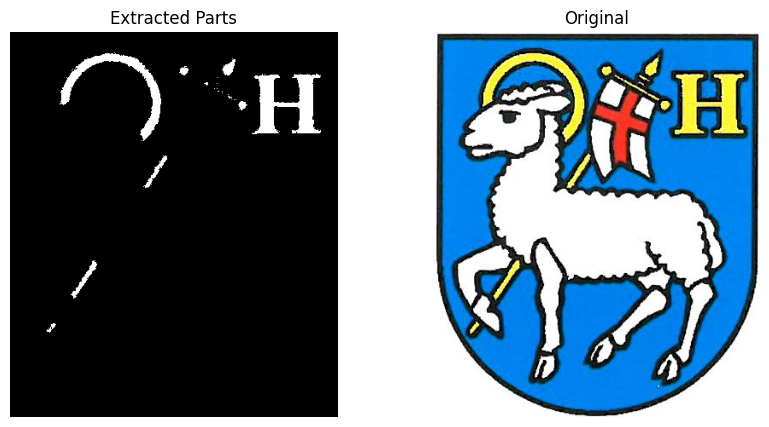

In [199]:
_ = calculate_color_ratio("./raw_data/coat_of_arms/1132.jpg",
                      yellow_start,
                      plot_image=True)

### 2.3. Get Dogs per Inhabitant

In [200]:
dogs_per_area = df_dogs.loc[:, ["Anzahl Hunde pro 100 Einwohner"]]

### 2.4. Merge all DataFrames

In [201]:
lu_data = base_data.join(df_color_ratio, on='Gemeindecode', how='left')
lu_data = lu_data.join(dogs_per_area, on='Gemeindecode', how='left')

display(lu_data.max())
lu_data.loc[lu_data.Gemeindename.isin(['Entlebuch', 'Romoos', 'Hasle', 'Hergiswil bei Willisau'])]

Gemeindename                                       Zell
Einwohner                                         82257
Bevölkerungsdichte pro km²                  2826.701031
0-19 Jahre                                    26.742712
20-64 Jahre                                   69.347496
65 Jahre und mehr                             27.032662
Gesamtfläche in km²                              108.17
Siedlungsfläche in %                          51.794872
Landwirtschaftsfläche in %                    80.597015
Wald und Gehölze in %                         60.803213
Leerwohnungsziffer                             7.028754
Neu gebaute Wohnungen pro 1000 Einwohner      30.803907
Rotanteil Wappen                               0.652303
Gelbanteil Wappen                              0.598907
Anzahl Hunde pro 100 Einwohner                     19.6
dtype: object

,Gemeindename,Einwohner,Bevölkerungsdichte pro km²,0-19 Jahre,20-64 Jahre,65 Jahre und mehr,Gesamtfläche in km²,Siedlungsfläche in %,Landwirtschaftsfläche in %,Wald und Gehölze in %,Leerwohnungsziffer,Neu gebaute Wohnungen pro 1000 Einwohner,Rotanteil Wappen,Gelbanteil Wappen,Anzahl Hunde pro 100 Einwohner
Gemeindecode,,,,,,,,,,,,,,,
1002,Entlebuch,3280,57.644991,21.798780,59.664634,18.536585,56.90,3.686151,49.552396,42.829559,1.092896,8.446456,0.651710,0.000000,10.0
1005,Hasle,1736,43.066237,22.695853,59.907834,17.396313,40.31,3.248202,49.094967,39.573518,2.241594,17.694064,0.000000,0.000000,9.2
1007,Romoos,659,17.625033,22.003035,59.787557,18.209408,37.39,2.088353,35.796519,60.803213,0.874636,0.000000,0.299652,0.444844,19.6
1132,Hergiswil bei Willisau,1905,60.784939,24.199475,58.320210,17.480315,31.34,4.626675,58.200383,36.407147,1.591187,1.572327,0.011910,0.036574,12.9


## 3. Create Ranking

In [202]:
def rank_normalized(values_to_rank: pd.Series, less_is_better: bool = False) -> pd.Series:
    '''
    Ranks a ``pd.Series`` by scaling its values in a range from 0 to 100 points.

    Parameters
    ----------
    values_to_rank : pd.Series
        The values to rank.
    less_is_better : bool, default
        Inverts the ranking when set to ``True``, so that the lowest value
        gets 100 points.
    
    Returns
    -------
    pd.Series
        A pandas Series containing the ranking for each input value. 
    '''
    value_range = values_to_rank.max() - values_to_rank.min()
    scaled_value = (values_to_rank - values_to_rank.min()) / value_range

    if less_is_better:
        scaled_value = 1 - scaled_value

    return (scaled_value * 100).round().astype('int')

def rank_custom(values_to_rank: pd.Series, winning_range: Tuple[float, float]) -> pd.Series:
    '''
    Ranks a ``pd.Series`` using a custom winning range and losing range. 
    
    Parameters
    ----------
    values_to_rank : pd.Series
        The values to rank.
    winning_range :  Tuple[float, float]
        Values which lie in the ``winning_range`` receive 100 points.
        Other values receive points based on their distance to the winning
        range. Both the lower and the upper bound are included in the range.

    Returns
    -------
    pd.Series
        A pandas Series containing the ranking for each input value. 
    '''

    ranking = values_to_rank.copy()

    # values in the winning range
    win_mask = values_to_rank.loc[(values_to_rank >= winning_range[0]) & (values_to_rank <= winning_range[1])].index
    ranking.loc[win_mask] = 100

    # values smaller then the winning range
    low_mask = values_to_rank.loc[values_to_rank < winning_range[0]].index
    ranking.loc[low_mask] = 100 * (values_to_rank[low_mask]) / (winning_range[0])

    # values larger then the winning range
    high_mask = values_to_rank.loc[values_to_rank > winning_range[1]].index
    ranking.loc[high_mask] = 100 * (1 - values_to_rank[high_mask]) / (1 - winning_range[1])
    
    return ranking.astype('int')

In [203]:
values = pd.Series([0.65, 0.125, 1, .5])
rank_custom(values, (0.25, 0.3))

v2 = pd.Series([0, 1, 0.225, 0.775])
rank_custom(v2, (0.45, 0.55))

0     0
1     0
2    50
3    50
dtype: int64

In [204]:
lu_ranked = lu_data.loc[:, ['Gemeindename']].copy()

lu_ranked['Punkte Waldanteil'] = lu_data.loc[:, 'Wald und Gehölze in %'].apply(
    rank_normalized,
    by_row=False)
lu_ranked['Punkte Neue Wohnungen'] = lu_data.loc[:, 'Neu gebaute Wohnungen pro 1000 Einwohner'].apply(
    rank_normalized,
    by_row=False, args=(True,))
lu_ranked['Punkte Rotanteil Wappen'] = lu_data.loc[:, 'Rotanteil Wappen'].apply(
    rank_custom,
    by_row=False, args=((0.25, 0.3),))
lu_ranked['Punkte Gelbanteil Wappen'] = lu_data.loc[:, 'Gelbanteil Wappen'].apply(
    rank_custom,
    by_row=False, args=((0.45, 0.55),))
lu_ranked['Punkte Anzahl Hunde pro Einwohner'] = lu_data.loc[:, 'Anzahl Hunde pro 100 Einwohner'].apply(
    rank_normalized,
    by_row=False)


lu_ranked['Gesamtpunkte'] = lu_ranked.iloc[:, 1:].apply(lambda row: row.mean(), axis=1)
lu_ranked.sort_values(by='Gesamtpunkte', ascending=False, inplace=True)
lu_ranked['Rang'] = np.arange(1, lu_ranked.shape[0] + 1)
lu_ranked.to_csv('ranks.csv')